# Analysis of Preprint Papers from the ArXiv

The website [arxiv.org](https://arxiv.org) is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract. The data set used here has been scraped from the [ArXiv API](https://arxiv.org/help/api) over several days, using the Python scraper `arxiv_scraper.py`.

To get a sense for how long the scraping takes, you can uncomment and run the script below.

In [1]:
#from arxiv_scraper import cat_scrape
#cat_scrape(
#    max_results_per_cat = 100, # maximum number of papers to download per category (there are ~150 categories)
#    file_path = "arxiv_data", # name of output file
#    batch_size = 100 # size of every batch - lower batch size requires less memory - must be less than 30,000
#)

Alternatively, I have downloaded metadata from about a million papers using this scraper (with `max_results_per_cat` = 10000), which can be freely downloaded below. This data set takes up ~1gb of space, however, so I've included many random samples of this data set as well:

* `arxiv` contains the main data set
* `arxiv_sample_1000` contains 1,000 papers
* `arxiv_sample_5000` contains 5,000 papers
* `arxiv_sample_10000` contains 10,000 papers
* `arxiv_sample_25000` contains 25,000 papers
* `arxiv_sample_50000` contains 50,000 papers
* `arxiv_sample_100000` contains 100,000 papers
* `arxiv_sample_200000` contains 200,000 papers
* `arxiv_sample_500000` contains 500,000 papers
* `arxiv_sample_750000` contains 750,000 papers

Choose your favorite below. Alternatively, of course, you can set it to be the file name of your own scraped data.

In [79]:
file_name = "arxiv_sample_1000"

We start by importing all the packages we will need and setting up a data directory.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # regular expressions
import pickle # enables saving data and models locally
import spacy as sp # used for lemmatising text

os.system("mkdir data") # create data directory

<h2> Fetching data </h2>

We then download the chosen data set --- if you've already scraped your own data set then skip this stage.

In [81]:
#!pip install wget # install if needed
import wget, os

url_start = f"https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/scholarly_data/"
# download the paper data
if not os.path.isfile(f'data/{file_name}.csv'):
    print(f"Downloading {file_name}.csv...", end = " ")
    wget.download(url_start + f"{file_name}.csv", out = f"data/{file_name}.csv")
    print("Done!")
else:
    print(f"{file_name}.csv already downloaded.")

arxiv_sample_1000.csv already downloaded.


Next, we download a list of all the arXiv categories and store them in `cats`.

In [84]:
# create directory if it does not already exist
os.system("mkdir data") 

# download a list of all the arXiv categories
if not os.path.isfile('data/cats.csv'):
    print("Downloading cats.csv...", end = " ")
    wget.download(url_start + "cats.csv", out = "data/cats.csv")
    print("Done!")
else:
    print("cats.csv already downloaded.")

# construct category dataframe and array
cats_df = pd.read_csv("data/cats.csv")
cats = np.asarray(cats_df['category'].values)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

cats.csv already downloaded.


,category,description
0,astro-ph,Astrophysics
1,astro-ph.CO,Cosmology and Nongalactic Astrophysics
2,astro-ph.EP,Earth and Planetary Astrophysics
3,astro-ph.GA,Astrophysics of Galaxies
4,astro-ph.HE,High Energy Astrophysical Phenomena


Next up we load the data into a dataframe. This might take a little while.

In [6]:
def nan_if_empty(x):
    ''' Converts empty lists/arrays to NaNs, making it easier to detect by pandas. '''
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    else:
        return arr

def remove_non_cats(x):
    ''' Removes every string in x which does not occur in the list of arXiv categories. '''
    return np.intersect1d(np.asarray(x), cats)

def str_to_arr(x):
    ''' Converts a string to a numpy array. '''
    return np.asarray(re.sub('[\' \[\]]', '', x).split(','))

def clean_cats(x):
    ''' Composition of nan_if_empty, remove_non_cats and str_to_arr. Used to clean scraped data. '''
    return nan_if_empty(remove_non_cats(str_to_arr(x)))

In [7]:
# set up dataframe
df = pd.read_csv(f'data/{file_name}.csv', converters={'category': clean_cats})[['title', 'abstract', 'category']]

print(f"Loaded metadata from {df.shape[0]} papers. Here are some of them:")
pd.set_option('display.max_colwidth', 300)
df.sample(3)

Loaded metadata from 1000 papers. Here are some of them:


,title,abstract,category
874,Status of the KIMS-NaI experiment,KIMS-NaI is a direct detection experiment searching for Weakly Interacting\nMassive Particles (WIMP) via their scattering off of nuclei in a NaI(Tl)\ncrystal. The KIMS-NaI collaboration has carried out tests of six crystals in\nthe Yangyang underground laboratory in order to develope low-backg...,"[hep-ex, physics.ins-det]"
869,Reduced-rank Analysis of the Total Least Squares,The reduced-rank method exploits the distortion-variance tradeoff to yield\nsuperior solutions for classic problems in statistical signal processing such\nas parameter estimation and filtering. The central idea is to reduce the\nvariance of the solution at the expense of introducing a little d...,"[cs.IT, math.IT]"
188,Pin(2)-equivariant Seiberg-Witten Floer homology of Seifert fibrations,"We compute the $\mathrm{Pin}(2)$-equivariant Seiberg-Witten Floer homology of\nSeifert rational homology three-spheres in terms of their Heegaard Floer\nhomology. As a result of this computation, we prove Manolescu's conjecture that\n$\beta=-\bar{\mu}$ for Seifert integral homology three-spher...",[math.GT]


<h2> Cleaning the data </h2>

We next do some basic cleaning of the data and saves the dataframe to `<file_name>_df.pickle`.

In [8]:
df_clean = df.copy()

# drop rows with NaNs
df_clean.dropna(inplace=True)

# merge title and abstract
df_clean['clean_text'] = df_clean['title'] + ' ' + df_clean['abstract']

# remove punctuation marks
punctuation ='\!\"\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~'
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x: re.sub(punctuation, '', x))

# convert text to lowercase
df_clean['clean_text'] = df_clean['clean_text'].str.lower()

# remove numbers
df_clean['clean_text'] = df_clean['clean_text'].str.replace("[0-9]", " ")

# remove whitespaces
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x:' '.join(x.split()))

pd.set_option('display.max_colwidth', 300)
df_clean[['title', 'abstract', 'clean_text']].sample(3)

,title,abstract,clean_text
329,"Linear spaces, transversal polymatroids and ASL domains","Let $K$ be an infinite field and $R=K[x_1,...,x_n]$ be the polynomial ring.\nLet $V=V_1, ..., V_m$ be a collection of vector spaces of linear forms. Denote\nby $A(V)$ the $K$-subalgebra of $R$ generated by the elements of the product\n$V_1... V_m$. Our goal is to investigate the properties of ...","linear spaces, transversal polymatroids and asl domains let $k$ be an infinite field and $r=k[x_ ,...,x_n]$ be the polynomial ring. let $v=v_ , ..., v_m$ be a collection of vector spaces of linear forms. denote by $a(v)$ the $k$-subalgebra of $r$ generated by the elements of the product $v_ ... ..."
131,Influence of paroxysmal activity on background synchronization in\n epileptic records,"The presence of spikes and sharp waves in the recordings of epileptic\npatients may contaminate background signal synchronization in different ways.\nIn this Technical Note, we present a simple procedure for assessing whether a\nparticular synchronization method should be used (or not) with da...","influence of paroxysmal activity on background synchronization in epileptic records the presence of spikes and sharp waves in the recordings of epileptic patients may contaminate background signal synchronization in different ways. in this technical note, we present a simple procedure for assess..."
39,Construction of enveloping actions,"We study the problem of constructing a globalization for partial actions on\n*-algebras, C*-algebras and Hilbert modules. For the first ones we give a\nnecessary condition for the existence of a globalization and we prove this\nconditions is necessary and sufficient for C*-algebras. Using the ...","construction of enveloping actions we study the problem of constructing a globalization for partial actions on *-algebras, c*-algebras and hilbert modules. for the first ones we give a necessary condition for the existence of a globalization and we prove this conditions is necessary and sufficie..."


Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This script is located in `lemmatiser.py`, uses `<file_name>_df.pickle`, and usually takes a little while to finish.

In [9]:
def lemmatise(texts):
    # import spacy's language model
    try:
        nlp = sp.load('en', disable=['parser', 'ner'])
    except:
        os.system("python -m spacy download en --user")
        nlp = sp.load('en', disable=['parser', 'ner']) 

    return np.asarray([' '.join(np.asarray([token.lemma_ for token in nlp(text)])) for text in texts])

In [10]:
df_lemm = df_clean.copy()

if not os.path.isfile(f"{file_name}_lemm.pickle"):
    df_lemm['clean_text'] = lemmatise(df_lemm['clean_text'])

    # save ELMo data
    with open(f"{file_name}_lemm.pickle", "wb") as pickle_out:
        pickle.dump(df_lemm, pickle_out)
else:
    # load ELMo data
    with open(f"{file_name}_lemm.pickle", "rb") as pickle_in:
        df_lemm = pickle.load(pickle_in)

pd.set_option('display.max_colwidth', 300)
df_lemm.sample(3)

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

<h2> One hot encoding of categories </h2>

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

In [11]:
def cat_to_binary(x):
    cat_index = np.nonzero(cats == x)[0][0]
    return [0] * cat_index + [1] + [0] * (len(cats) - cat_index - 1)

def cats_to_binary(x):
    binary_cat = np.sum([cat_to_binary(y) for y in x], 0, dtype=np.int32)
    return binary_cat.tolist()

print("One-hot encoding...", end = " ")

df_1hot = df_lemm.copy()

# populate cats_df with the information from df
bincat_list = np.array([cats_to_binary(x) for x in df_1hot['category']]).transpose().tolist()
bincat_dict = {key:value for (key,value) in list(zip(cats, bincat_list))}
bincat_df = pd.DataFrame.from_dict(bincat_dict)

# concatenate df with the columns in cats_df
df_1hot = pd.concat([df_1hot, bincat_df], axis=1, sort=False)

# drop the category column
df_1hot.drop(['category'], axis=1, inplace=True)

print("Done!")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
df_1hot.sample(3)

One-hot encoding... Done!


,title,abstract,clean_text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
975,Self S...,Occu...,self s...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
376,Geomet...,We p...,geomet...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
737,Stocha...,In c...,stocha...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> Analysis of the data </h2>

Here is how the categories in our data set are distributed.

In [12]:
# save a dataframe with the amount of papers in each category
sum_cats = bincat_df.apply(lambda x: x.sum())

# get statistical information about the distribution of the amount of papers
sum_cats.describe()

count    153.00...
mean     14.450980
std      11.656792
min       0.000000
25%       5.000000
50%      12.000000
75%      20.000000
max      55.000000
dtype: float64

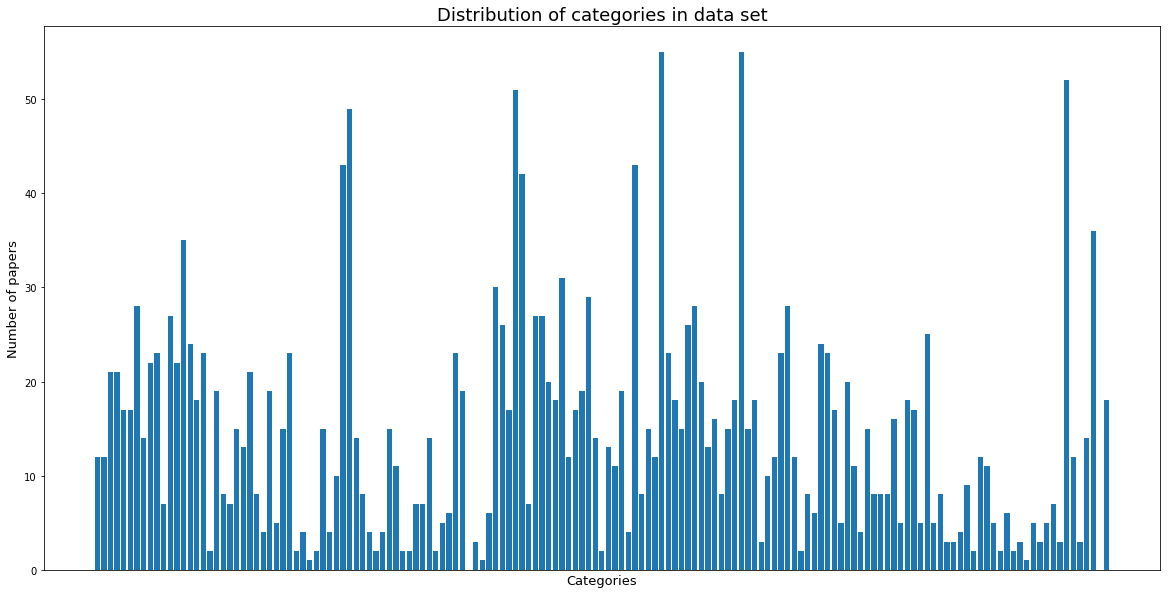

In [13]:
# plot the distribution of the amount of papers in each category
plt.figure(figsize=(20,10))
plt.bar(x=sum_cats.keys(), height=sum_cats.values)
plt.xlabel('Categories', fontsize=13)
plt.ylabel('Number of papers', fontsize=13)
plt.title('Distribution of categories in data set', fontsize=18)
plt.xticks([])
plt.show()

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

In [48]:
# add the counts to the dataframe and sort 
cats_df['count'] = sum_cats.values
cats_df = cat_df.sort_values(by=['count'], ascending=False)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

,category,description,count
85,math.MP,Mathematical Physics,55
97,math-ph,Mathematical Physics,55
146,quant-ph,Quantum Physics,52
63,hep-ph,High Energy Physics - Phenomenology,51
38,cs.LG,Learning,49


<h2> ELMo feature extraction </h2>

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will need the following extra packages.

Next, we download the ELMo model. It is over 350mb in size, so it might take a little while.

In [15]:
import tarfile

if not os.path.isdir("elmo"):
    # download ELMo model
    print("Downloading compressed ELMo model...", end = " ")
    url = "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed"
    wget.download(url, out="elmo.tar.gz")
    print("Done!")

    # uncompress ELMo model
    print("Uncompressing into the 'elmo' directory...", end = " ")
    os.system("mkdir elmo") # create directory
    with tarfile.open("elmo.tar.gz") as tar:
        tar.extractall("elmo")
    os.remove("elmo.tar.gz")
    print("Done!")
else:
    print("The 'elmo' directory already exists, so assuming that the model has been downloaded.")

The 'elmo' directory already exists, so assuming that the model has been downloaded.


We now need to extract ELMo features from our cleaned text data. This is done using the `extract` function from `elmo.py`. This usually takes a LONG time.

In [23]:
from elmo import extract

if not os.path.isfile(f"{file_name}_elmo.pickle"):
    # extract ELMo data
    elmo_data = extract(
        df_1hot['clean_text'], 
        batch_size = 50 # lower batch size results in less accurate ELMo vectors but requires fewer computational resources
    )

    # save ELMo data
    with open(f"{file_name}_elmo.pickle", "wb") as pickle_out:
        pickle.dump(elmo_data, pickle_out)

    print(f"ELMo extraction completed. Also saved elmo data to {file_name}.elmo.pickle.")
else:
    # load ELMo data
    with open(f"{file_name}_elmo.pickle", "rb") as pickle_in:
        elmo_data = pickle.load(pickle_in)

    print(f"ELMo data loaded from {file_name}_elmo.pickle.")

print(f"Shape of elmo_data: {elmo_data.shape}")

ELMo data loaded from arxiv_sample_1000_elmo.pickle.
Shape of elmo_data: (1000, 1024)


In [49]:
df_elmo = pd.DataFrame(elmo_data)
df_elmo = df_elmo.join(pd.DataFrame(df_1hot.drop(columns=['title', 'abstract', 'clean_text'])))
df_elmo.head()

,0,1,2,3,4,5,6,7,8,9,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,0.033354,0.021098,0.000053,-0.005448,-0.041345,-0.095134,0.022219,0.111372,-0.070493,-0.134927,...,0,0,0,0,0,0,0,0,0,0
1,0.007549,0.000053,0.043732,0.001210,0.048420,-0.007204,-0.040292,0.066277,-0.043792,-0.177578,...,0,0,0,0,0,0,0,0,0,0
2,-0.037260,-0.017322,0.016323,-0.012784,0.003913,0.026283,0.013110,0.151467,-0.040286,-0.139726,...,0,0,0,0,0,0,0,0,0,0
3,0.018917,0.087698,0.040531,-0.027623,-0.042850,-0.034921,0.027271,0.221651,-0.095317,-0.188114,...,0,0,0,0,0,0,0,0,0,0
4,-0.017598,0.070381,-0.032622,0.032497,0.012580,-0.080579,0.022940,0.059791,0.033615,-0.137217,...,0,0,0,0,0,0,0,0,0,0


<h2> Building the model </h2>

We are now done manipulating our data, and the time has come to build a model. We will be building a logistic regression model for every category.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [50]:
Y_test = []
Y_hat = []
lregs = np.asarray([])

for cat in cats:
        
    X_train, X_test, y_train, y_test = train_test_split(df_elmo, df_elmo[cat], test_size=0.2)
    Y_test.append(y_test)
    
    try:
        lreg = LogisticRegression(C=0.0001, solver='liblinear')
        lreg.fit(X_train, y_train)
        Y_hat.append(lreg.predict(X_test))
        lregs.append(lreg)
    except:
        Y_hat.append(np.array([0] * len(y_test)))

<h2> Testing the model </h2>

We now check whether our model is capable of predicting the categories for the papers in our test set.

In [51]:
from sklearn.metrics import f1_score
from statistics import mean

In [52]:
f1s = [f1_score(x, y) for (x,y) in zip(Y_test, Y_hat)]

print(f"The average f1 score for the model is {mean(f1s)}.")

C:\Users\dn16382\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The average f1 score for the model is 0.0.
